# GAN
## Generative Adversarial Networks
### Brian Sisney

In [1]:
# To generate GIFs
# pip install imageio
# pip install git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
tf.__version__

'2.10.0'

In [3]:
# Load the dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data. Pixel values range from 0 to 255.

y_train: uint8 NumPy array of digit labels (integers in range 0-9) with shape (60000,) for the training data.

In [4]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [5]:
train_labels[0]

5

In [6]:
# (train_labels == (2 or 5))
arr = (train_labels == 2) | (train_labels == 5) | (train_labels == 6) | (train_labels == 9) | (train_labels == 1) | (train_labels == 7)
print(arr.sum())
print(len(train_labels))
# print(arr.sum())
# print(len(train_labels))
train_images = train_images[arr]
train_labels = train_labels[arr]

36253
60000


In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

#### skip
#### what is reshape?
Gives a new shape to an array without changing its data.
#### what is shape?
this returns the current shape and here its basically just finding the correct number of elements and then putting each value into its own array.
#### how does this normalize?
This is putting the values from 0-255 into values between -1 and 1

In [8]:
# TODO maybe try this with only 1s and 8s or 3s and 8s? or 2s and 5s or 6 and 9?

In [9]:
# these are the normalized training arrays
train_images[0]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### skip
#### what are tensors
Tensors are multi-dimensional arrays with a uniform type (called a dtype), tensors are (kind of) like np.arrays.
#### what is from_tensor_slices
basically remove the outer array and return as a dataset.
#### what is shuffle 
Randomly shuffles the elements of this dataset. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
#### What is batch?
Combines consecutive elements of this dataset into batches. The components of the resulting element will have an additional outer dimension, which will be batch_size. 
#### what is Keras Sequential API?
Keras sequential creates the model layer-by-layer. It takes only one input as feed and expects one output. Sharing layers or branching layers is not allowed, also you can’t have multiple inputs or outputs.

#### *
Both the generator and discriminator are defined using the Keras Sequential API.

#### The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image 
from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#### skip
#### what is tf.keras.layers.Conv2DTranspose/upsampling?
Transposed convolution layer (sometimes called Deconvolution)
This goes the opposite direction than normal convolution. Basically it takes the 100 length array and the builds an image. 

Upsampling is backwards strided convolution

tf.keras.layers.Conv2DTranspose(
    filters,
    kernel_size,
    strides=(1, 1)...)

filters - Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

kernel_size - An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.

#### what is tf.keras.layers.LeakyReLU ?
Leaky version of a Rectified Linear Unit.
It allows a small gradient when the unit is not active:
    often alpha is 0.1
f(x) = alpha * x if x < 0
f(x) = x if x >= 0
    
    
#### what is tanh?
Hyperbolic Tangent 
very similar to the sigmoid activation function and even has the same S-shape
Basically takes input -1 to 1 where sigmoid is 0 to 1

#### what is BatchNormalization?
Layer that normalizes its inputs.
Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.
Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

During training (i.e. when using fit()), the layer normalizes its output using the mean and standard deviation of the current batch of inputs. For each channel being normalized, the layer returns gamma * (batch - mean(batch)) / sqrt(var(batch) + epsilon) + beta, where:

During inference (i.e. when using evaluate() or predict()), the layer normalizes its output using a moving average of the mean and standard deviation of the batches it has seen during training. It returns gamma * (batch - self.moving_mean) / sqrt(self.moving_var+epsilon) + beta.

#### what is layers.Dense? 
Just your regular densely-connected NN layer.
A Dense layer classifies the data. This hidden layer is connected to every node in the subsequent hidden layer and applies an activation algorithm to reduce and classify the vector. As in this example, you can use more than one Dense layer but the final layer's output number should match the number of output classes.



#### what are strides?
how much the convolutaions are moving on the base array. 

#### why 7 7 256?
256 comes from the output image is 28 and the layers are cut in half each time. the 7 and 7 are based on the convolution layers. 
I believe it is taking an 1 d array of 100, and transposing it to build the output shape.  


In [13]:
# Use the (as yet untrained) generator to create an image.
generator = make_generator_model()

noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.09334277,  0.15100412,  0.08460061,  0.49535927,  0.7290679 ,
        -0.34392834, -0.78664947, -0.805939  , -1.5446047 ,  1.1172531 ,
        -1.1538464 , -1.2647614 , -0.57619804,  0.7423759 , -0.77349836,
        -0.08170733, -1.3387275 , -0.5569822 , -1.3329573 , -0.08326915,
        -0.7830429 ,  0.32540584,  1.1618382 , -0.26829752,  0.6187581 ,
         0.5978051 , -3.1804824 , -0.46103925,  0.25875422, -0.97682977,
         0.22879425, -1.1942989 ,  0.6284382 , -0.29486972,  0.5827946 ,
        -0.822147  ,  0.82401234, -0.0685056 , -0.3374486 , -1.8335345 ,
         0.38018316, -1.1025224 ,  1.4167495 , -1.1556878 ,  2.5078912 ,
        -2.075693  , -0.5812869 , -0.1404591 ,  0.6396924 , -0.39013258,
         1.1384878 ,  0.48051956,  0.7450745 ,  0.7839743 ,  0.80199176,
         1.1015112 ,  0.6890237 ,  0.7963452 ,  0.40996185,  0.02858071,
         0.8051348 ,  0.83792555, -1.2271996 , -0.85132146, -0.34077108,
 

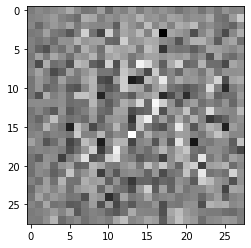

In [14]:
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### The Discriminator
The discriminator is a CNN-based image classifier.

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

#### skip
#### what is Conv2D
2D convolution layer. 
This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. 

#### what is Dropout?
Applies Dropout to the input.
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.

#### what is flatten?
Flattens the input. Does not affect the batch size.
Flattens the input by unrolling the matrices into one long layer.



In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00043252]], shape=(1, 1), dtype=float32)


#### Define the loss and optimizers
Define loss functions and optimizers for both models.

In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### skip
#### what is entropy?
entropy is the machine learning metric that measures the unpredictability or impurity in the system.
it uses the log function to calculate the likelyhood you will pull out a class of values out of all values. like red balls vs a mix of colors of balls. 

-(probability_of_red * log(probablity_of_red) + probablity_of_rest * log(probability_of_rest))

taking the log of a fraction will result in a negative number, which is why we have to multiply by -1. 

Its a log funtion meaning: entropy of 1 is it could go anyway. entropy of 0 is that it is certain. 

If there are 3 classes the entropy could be above 1 like if the classes were split .25, .25, .5 then entropy would be 1.5.

Information Gain = (Entropy of parent node)-(Entropy of child node)


#### what is cross entropy
Cross-entropy is commonly used in machine learning as a loss function.
cross-entropy can be thought to calculate the total entropy between the distributions.
Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events.
You might recall that information quantifies the number of bits required to encode and transmit an event. Lower probability events have more information, higher probability events have less information

used to optimize classification models

#### what is BinaryCrossentropy
Computes the cross-entropy loss between true labels and predicted labels.
Use this cross-entropy loss for binary (0 or 1) classification applications. The loss function requires the following inputs:

y_true (true label): This is either 0 or 1.
y_pred (predicted value): This is the model's prediction, i.e, a single floating-point value which either represents a logit, (i.e, value in [-inf, inf] when from_logits=True) or a probability (i.e, value in [0., 1.] when from_logits=False).


#### What's the softmax function do?
The softmax function shows the likelihood the prediction is correct. It provides probabilities for each possible class, which all add to 1. For example, softmax might determine the probability of a particular image being a dog at 0.9, a cat at 0.08, and a horse at 0.02.

#### *

#### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
# The discriminator and the generator optimizers are different since you will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### skip
#### what are optimzers?
An optimizer is one of the two arguments required for compiling a Keras model

#### what is Adam?
Optimizer that implements the Adam algorithm. It startes with your learning rate (1e-4) and then as the epochs prgress it applies its learning less and less. 

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.


#### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Checkpoints capture the exact value of all parameters (tf.Variable objects) used by a model.

#### Define the training loop

In [22]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# random.normal - normal means Gaussian distribution

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### skip
#### what is tf.function?
Compiles a function into a callable TensorFlow graph

#### what is GradientTape?
Record operations for automatic differentiation.
Operations are recorded if they are executed within this context manager and at least one of their inputs is being "watched".

In [24]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### Train the model
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

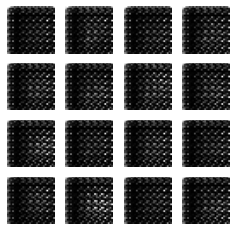

Time for epoch 1 is 61.26417422294617 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#### Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

#### what is PIL?
Python Imaging Library that gives your Python interpreter access to image processing functions
#### What is Image?
The Image module provides a class with the same name which is used to represent a PIL image. The module also provides a number of factory functions, including functions to load images from files, and to create new images.

In [ ]:
display_image(EPOCHS)

Use imageio to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)